The main reason that the KL divergence of $P(k)$ is negative is because there's a significant bias caused by the $k$-NN estimator. 

In [1]:
import numpy as np
from scipy.special import gamma as Gamma
from scipy.special import gammaln as GammaLn
from numpy.random import multivariate_normal as mvn 
from scipy.stats import multivariate_normal as multinorm
#
from sklearn.neighbors import NearestNeighbors
# -- nonGaussLike -- 
from nongausslike import knn as kNN
from nongausslike import nongauss as NG

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
X_pk = NG.X_pk_all('patchy.z1', NorS='ngc', sys='fc')
X_res, _ = NG.meansub(X_pk)
X_w, W = NG.whiten(X_res)
C_x = np.cov(X_w.T)

n, dim = X_pk.shape
print("%i dimensional data with %i samples" % (dim, n))

X_ref = mvn(np.zeros(dim), C_x, size=n)

37 dimensional data with 2048 samples


In [9]:
def c_1(d): 
    return np.pi**(0.5 * float(d)) / Gamma(0.5*float(d)+1)

In [4]:
def hat_p(X, k=10): 
    n, d = X.shape # n and dimensions
    k, n, d = float(k), float(n), float(d)

    # kNN term
    NN_X = NearestNeighbors(n_neighbors=int(k)).fit(X)
    dNN_XX, _ = NN_X.kneighbors(X, n_neighbors=int(k)+1) # k+1 to exclude itself
    rho_k_i = dNN_XX[:,-1]
    
    return k/(n-1) * 1 / (c_1(d) * rho_k_i**d)

In [7]:
def p(X): 
    return multinorm.pdf(X, mean=np.zeros(dim), cov=C_x)

In [28]:
ks = [1, 3, 5, 7, 10, 15, 20, 100, 1000]
pX_ref = p(X_ref)
hat_pX_ref = []
for k in ks: 
    hat_pX_ref.append(hat_p(X_ref, k=k))
hat_pX_ref = np.array(hat_pX_ref)

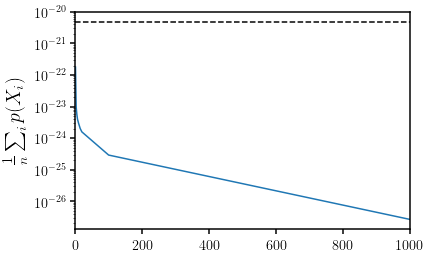

In [29]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(ks, np.average(hat_pX_ref, axis=1))
sub.plot(ks, np.repeat(np.average(pX_ref), len(ks)), c='k', ls='--')
sub.set_xlim([0, ks[-1]])
sub.set_ylabel(r'$\frac{1}{n}\sum_{i} p(X_i)$', fontsize=20)
sub.set_yscale('log')

Text(0,0.5,'$\\frac{1}{n}\\sum_{i} \\log p(X_i)$')

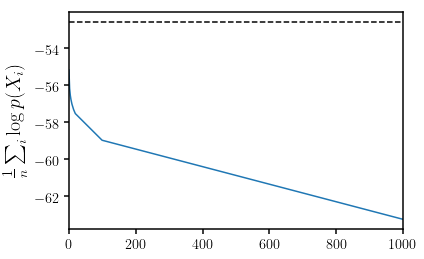

In [30]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(ks, np.average(np.log(hat_pX_ref), axis=1))
sub.plot(ks, np.repeat(np.average(np.log(pX_ref)), len(ks)), c='k', ls='--')
sub.set_xlim([0, ks[-1]])
sub.set_ylabel(r'$\frac{1}{n}\sum_{i} \log p(X_i)$', fontsize=20)
#sub.set_yscale('log')

In [31]:
X_ref2 = mvn(np.zeros(dim), C_x, size=2*n)
X_ref3 = mvn(np.zeros(dim), C_x, size=10*n)

In [32]:
pX_ref2 = p(X_ref2)
pX_ref3 = p(X_ref3)
hat_pX_ref2, hat_pX_ref3 = [], []
for k in ks: 
    hat_pX_ref2.append(hat_p(X_ref2, k=k))
    hat_pX_ref3.append(hat_p(X_ref3, k=k))
hat_pX_ref2 = np.array(hat_pX_ref2)
hat_pX_ref3 = np.array(hat_pX_ref3)

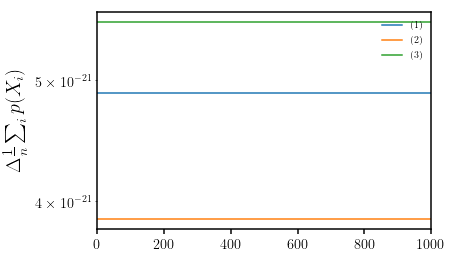

In [43]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(ks, np.repeat(np.average(pX_ref), len(ks)), label='(1)')
sub.plot(ks, np.repeat(np.average(pX_ref2), len(ks)), label='(2)')
sub.plot(ks, np.repeat(np.average(pX_ref3), len(ks)), label='(3)')
sub.legend(loc='upper right')
sub.set_xlim([0, ks[-1]])
sub.set_ylabel(r'$\Delta \frac{1}{n}\sum_{i} p(X_i)$', fontsize=20)
sub.set_yscale('log')

In [51]:
(hat_pX_ref - pX_ref).shape

(9, 2048)

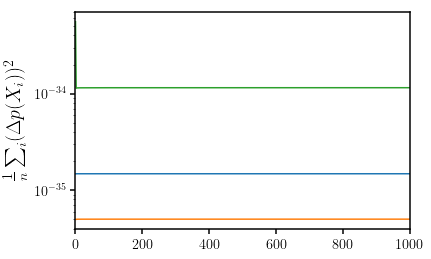

In [57]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(ks, np.sum((hat_pX_ref - pX_ref)**2, axis=1))
sub.plot(ks, np.sum((hat_pX_ref2 - pX_ref2)**2, axis=1))
sub.plot(ks, np.sum((hat_pX_ref3 - pX_ref3)**2, axis=1))
sub.set_xlim([0, ks[-1]])
sub.set_ylabel(r'$\frac{1}{n}\sum_{i} (\Delta p(X_i))^2$', fontsize=20)
sub.set_yscale('log')

Text(0,0.5,'$\\Delta \\frac{1}{n}\\sum_{i} \\log p(X_i)$')

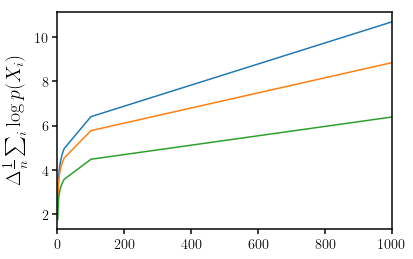

In [55]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(ks, np.average(np.log(pX_ref)) - np.average(np.log(hat_pX_ref), axis=1))
sub.plot(ks, np.average(np.log(pX_ref2)) - np.average(np.log(hat_pX_ref2), axis=1))
sub.plot(ks, np.average(np.log(pX_ref3)) - np.average(np.log(hat_pX_ref3), axis=1))
sub.set_xlim([0, ks[-1]])
sub.set_ylabel(r'$\Delta \frac{1}{n}\sum_{i} \log p(X_i)$', fontsize=20)
#sub.set_yscale('log')

In [65]:
X_ref = mvn(np.zeros(5), C_x[:5,:5], size=100*n)

In [66]:
ks = [1, 3, 5, 7, 10, 15, 20, 100, 1000]
pX_ref = multinorm.pdf(X_ref, mean=np.zeros(5), cov=C_x[:5,:5])
hat_pX_ref = []
for k in ks: 
    hat_pX_ref.append(hat_p(X_ref, k=k))
hat_pX_ref = np.array(hat_pX_ref)

(1e-05, 0.001)

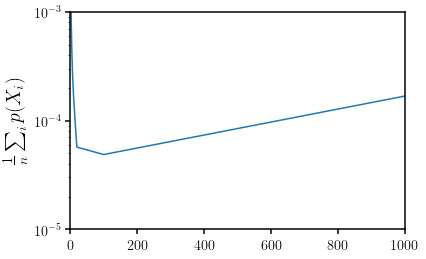

In [73]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot(ks, np.abs(np.average(hat_pX_ref, axis=1)-np.repeat(np.average(pX_ref), len(ks))))
sub.plot(ks, np.zeros(len(ks)), c='k', ls='--')#np.repeat(np.average(pX_ref), len(ks)), c='k', ls='--')
sub.set_xlim([0, ks[-1]])
sub.set_ylabel(r'$\frac{1}{n}\sum_{i} p(X_i)$', fontsize=20)
sub.set_yscale('log')
sub.set_ylim([1e-5, 1e-3])